# CITY LIFE. Geospatial analysis

## Task

In this project, you will try to get some valuable insights about customers’
and taxi drivers’ behavior. Maybe it will help a taxi company optimize its
business.
Here are the tasks that you need to do:
1. find out and visualize on a map most popular areas where people ordered a taxi as
well as where they headed to,
2. find out and visualize the most popular routes in different time intervals,
3. find in the dataset locations of the city infrastructure and visualize how the customers were arriving at one of them using an animated map,
4. visualize one day of a taxi driver and how much money he or she earned using an
animated map,
5. visualize one day of the city (working day and weekend day) using an animated
map.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import folium


from shapely.geometry import Polygon, LineString, Point

from sklearn.cluster import KMeans


## Load data

In [3]:
df_map = gpd.read_file('data/chicago_map.shx')

In [4]:
df_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  77 non-null     geometry
dtypes: geometry(1)
memory usage: 744.0 bytes


In [5]:
rush = gpd.read_file('data/rush_hours_empty.csv')

In [6]:
rush.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   name                1 non-null      object  
 1   longitude           1 non-null      object  
 2   latitude            1 non-null      object  
 3   num_of_rides        1 non-null      object  
 4   Trip End Timestamp  1 non-null      object  
 5   geometry            0 non-null      geometry
dtypes: geometry(1), object(5)
memory usage: 176.0+ bytes


In [7]:
taxi_loc = gpd.read_file('data/taxi_locations.csv')

In [8]:
taxi_loc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2506294 entries, 0 to 2506293
Data columns (total 12 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   Trip ID                     object  
 1   Pickup Centroid Latitude    object  
 2   Pickup Centroid Longitude   object  
 3   Pickup Centroid Location    object  
 4   Dropoff Centroid Latitude   object  
 5   Dropoff Centroid Longitude  object  
 6   Dropoff Centroid  Location  object  
 7   Trip Start Timestamp        object  
 8   Trip End Timestamp          object  
 9   Taxi ID                     object  
 10  Fare                        object  
 11  geometry                    geometry
dtypes: geometry(1), object(11)
memory usage: 229.5+ MB


## Data preparation

In [9]:
df_map.set_crs(epsg=4326, inplace=True)

,geometry
0,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...
72,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


In [10]:
m = folium.Map(location=[41.85, -87.65], zoom_start=10, tiles='CartoDB positron')

In [11]:
for _, r in df_map.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
# for _, r in taxi_loc.iterrows():
#     folium.CircleMarker(
#         location=[r['Pickup Centroid Latitude'], r['Pickup Centroid Longitude']],
#         radius=5,
#         color='blue',
#         fill=True,
#         fill_coloue='blue'
#     ).add_to(m)

In [12]:
m

### Dates to daytime

In [13]:
taxi_loc['Trip Start Timestamp'] = pd.to_datetime(taxi_loc['Trip Start Timestamp'])
taxi_loc['Trip End Timestamp'] = pd.to_datetime(taxi_loc['Trip End Timestamp'])

In [14]:
rush['Trip End Timestamp'] = pd.to_datetime(rush['Trip End Timestamp'])

### Dropoff and Pickup columns to geometry type

In [15]:
taxi_loc['Pickup Centroid Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Pickup Centroid Location'])
taxi_loc['Dropoff Centroid  Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Dropoff Centroid  Location'])

In [16]:
taxi_loc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2506294 entries, 0 to 2506293
Data columns (total 12 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip ID                     object        
 1   Pickup Centroid Latitude    object        
 2   Pickup Centroid Longitude   object        
 3   Pickup Centroid Location    geometry      
 4   Dropoff Centroid Latitude   object        
 5   Dropoff Centroid Longitude  object        
 6   Dropoff Centroid  Location  geometry      
 7   Trip Start Timestamp        datetime64[ns]
 8   Trip End Timestamp          datetime64[ns]
 9   Taxi ID                     object        
 10  Fare                        object        
 11  geometry                    geometry      
dtypes: datetime64[ns](2), geometry(3), object(7)
memory usage: 229.5+ MB


### Check for NaN values and duplicates

In [50]:
taxi_loc.isna().sum()

Trip ID                             0
Pickup Centroid Latitude            0
Pickup Centroid Longitude           0
Pickup Centroid Location            0
Dropoff Centroid Latitude           0
Dropoff Centroid Longitude          0
Dropoff Centroid  Location          0
Trip Start Timestamp                0
Trip End Timestamp                  0
Taxi ID                             0
Fare                                0
geometry                      2506294
dtype: int64

In [64]:
points_pick = gpd.GeoDataFrame(taxi_loc, geometry='Pickup Centroid Location', crs=df_map.crs)

In [65]:
pointInPolys = gpd.tools.sjoin(points_pick, df_map, predicate="within", how='left')

In [66]:
pointInPolys

,Trip ID,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Trip Start Timestamp,Trip End Timestamp,Taxi ID,Fare,geometry,pickup_cluster,dropoff_cluster,index_right
0,304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,41.878865584,-87.625192142,POINT (-87.62519 41.87887),41.77887686,-87.594925439,POINT (-87.59493 41.77888),2014-10-12 20:30:00,2014-10-12 20:45:00,ada14d22a0c2f8c7fe79140611a8e76602acdd8b448282...,19.25,None,2,1,37.0
1,b1a8b95ea294663cc3d3cb38a538f464418288c4,41.947791586,-87.683834942,POINT (-87.68383 41.94779),41.874005383000004,-87.66351755,POINT (-87.66352 41.87401),2014-10-12 20:30:00,2014-10-12 20:45:00,92ab37c26efa3b2659e525a0a2ae31e69c84ffd7bcfef2...,13.05,None,0,1,45.0
2,752c8ac4bdf62db4c3d4e810cab915a0ec0ceddc,42.001571027,-87.695012589,POINT (-87.69501 42.00157),42.001571027,-87.695012589,POINT (-87.69501 42.00157),2014-09-09 18:00:00,2014-09-09 18:00:00,d06d9962fe86645dd59a7dce41cf27734b23dc62974283...,4.85,None,0,1,19.0
3,6808fa8dc0d009190da2e2416203a7ba012f45a9,41.90156691,-87.63840401200001,POINT (-87.63840 41.90157),41.90156691,-87.63840401200001,POINT (-87.63840 41.90157),2014-10-12 06:30:00,2014-10-12 06:30:00,26d0351db732d6b194d3ae9f29b4a3c53070fdd14aa3c9...,3.25,None,2,1,36.0
4,01428cb986d678ea0a8d39b6b35d05d06baa631a,41.892042136,-87.63186395,POINT (-87.63186 41.89204),41.97907082,-87.90303966100002,POINT (-87.90304 41.97907),2014-09-07 17:45:00,2014-09-07 18:45:00,25b37d641316c0ca5cb44edf8eaf9f012e2495549f60b7...,38.25,None,2,0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506289,21bc604a66e2c479f767bdfd6ddfec6a7b57065b,41.97907082,-87.90303966100002,POINT (-87.90304 41.97907),41.880994471,-87.632746489,POINT (-87.63275 41.88099),2019-06-16 22:30:00,2019-06-16 23:00:00,f6591bb5699bde5f19f3074a76774808dd0e5c941ee0ed...,44.25,None,1,1,74.0
2506290,21beff87d222ce3c0e1c62f9278c1ed8a455550a,41.922686284,-87.649488729,POINT (-87.64949 41.92269),41.922686284,-87.649488729,POINT (-87.64949 41.92269),2019-06-03 11:00:00,2019-06-03 11:15:00,6161b78168fb8a51b06c3994f62522e1d21390a969e3b1...,4.25,None,0,1,67.0
2506291,21baf5e9060fb66f7b5e11444d32d07275a3a2ee,41.879255084,-87.642648998,POINT (-87.64265 41.87926),41.880994471,-87.632746489,POINT (-87.63275 41.88099),2019-06-15 13:45:00,2019-06-15 13:45:00,025c4a64d4348a8184bbf4109fea03a717b87f48029d95...,10.75,None,2,1,28.0
2506292,21bfa342fb04bdf42585c216c9da58cc5a6975f2,41.884987192,-87.620992913,POINT (-87.62099 41.88499),41.890922026,-87.618868355,POINT (-87.61887 41.89092),2019-06-05 17:15:00,2019-06-05 17:15:00,e39f9fb04c45fac83b35fbc9c36b68ba97cdf877dd76fd...,5.75,None,2,1,37.0


## 1. Most popular areas

1. Conduct clustering analysis of pick point and drop off locations based on their coordinates. Clusters might be different for each of the categories (pickpoints and drop-offs).

### Pickpoints

In [32]:
pickups = taxi_loc[['Pickup Centroid Latitude', 'Pickup Centroid Longitude']]

We need to define the best number of clusters. In order to do this we can use elbow rule

#### Elbow curve

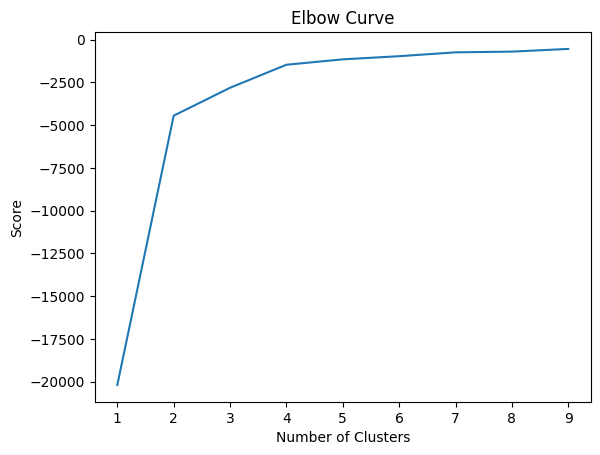

In [58]:
K_clusters = range(1,10)
kmeans = [KMeans(init="random",
                 n_clusters=i,
                 max_iter=300,
                 random_state=42,
                 n_init='auto') for i in K_clusters]
score = [kmeans[i].fit(pickups).score(pickups) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

2? clasters is optimal

In [59]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [60]:
kmeans.fit_predict(pickups)
pickup_labels = kmeans.labels_
taxi_loc['pickup_cluster'] = pickup_labels

array([2, 0, 0, ..., 2, 2, 3], dtype=int32)

### Drop-offs

In [43]:
dropoffs = taxi_loc[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]

#### Elbow curve

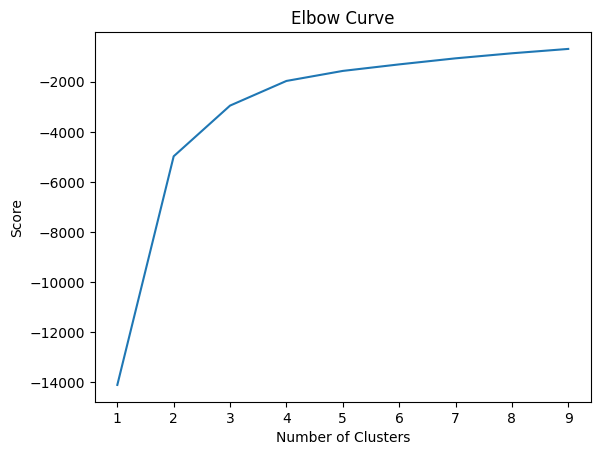

In [46]:
K_clusters = range(1,10)
kmeans = [KMeans(init="random",
                 n_clusters=i,
                 max_iter=300,
                 random_state=42,
                 n_init='auto') for i in K_clusters]
score = [kmeans[i].fit(dropoffs).score(dropoffs) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

4 clusters is optimal

In [62]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [63]:
kmeans.fit_predict(dropoffs)
dropoff_labels = kmeans.labels_
taxi_loc['dropoff_cluster'] = dropoff_labels

2. Draw the borders and centroids of the clusters on a map. You will have two maps.

3. Use a color scale to show which clusters (i.e. areas) have the largest number of pick
points and drop-offs.

## 2. Most popular routes

## 3. City infrastructure

## 4. One day of a taxi driver

## 5. One day of the city

## Bonus